In [160]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [161]:
class Maze:
    #  setting up the maze
    def __init__(self,maze,start_position,end_position):
        self.maze=maze
        self.start_position = start_position
        self.end_position = end_position
        self.maze_width = maze_layout.shape[0]
        self.maze_height= maze_layout.shape[1]
        
    def show_maze(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.maze,cmap='gray')
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center',va='center',color='red',fontsize=20)
        plt.text(self.end_position[0], self.end_position[1], 'E', ha='center',va='center',color='green',fontsize=20)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
    
        

In [162]:
maze_layout = np.array([
    [0,1,0,0,0],
    [0,1,1,1,0],
    [0,0,0,1,0],
    [1,1,0,1,1],
    [0,0,0,0,0],
])

In [163]:
maze = Maze(maze_layout,(0,0),(4,4))

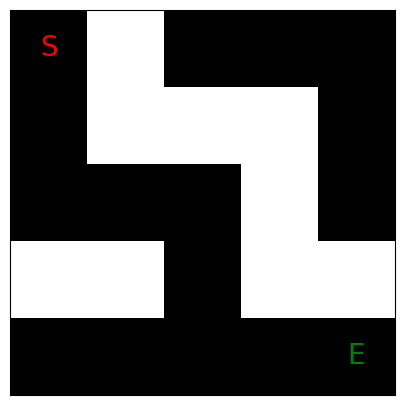

In [164]:
maze.show_maze()

In [165]:
actions = [(-1,0),(1,0),(0,-1),(0,1)] # move up, down, left and right

In [166]:
class Agent:
    def __init__(self, maze, learning_rate=0.1,discount_factor=0.9,exploration_start=1.0,exploration_end=0.01, epochs=100):
        self.q_table = np.zeros((maze.maze_height,maze.maze_width,4))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.epochs = epochs
    def get_exploration_rate(self,current_episode):
        exploration_rate = self.exploration_start * (self.exploration_end/ self.exploration_start) ** (current_episode/self.epochs)
        return exploration_rate
    def get_action(self,state , current_episode):
        exploration_rate = self.get_exploration_rate(current_episode)
        
        if np.random.rand() < exploration_rate:
            return np.random.randint(4)
        else:
            return np.argmax(self.q_table[state])
        
    def update_q_table(self, state,action,next_state,reward):
        best_next_action = np.argmax(self.q_table[next_state])
        current_q_value = self.q_table[state][action]
        new_q_value = current_q_value  + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action] - current_q_value)
        
        

In [167]:
goal_reward = 100
wall_penalty = -10
step_penalty = -1

In [168]:
def finish_episode ( agent  , maze , current_episode , train = True):
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]
    
    while not is_done:
        action = agent.get_action(current_state,current_episode)
        next_state = (current_state[0]+ actions[action][0], current_state[1] + actions[action][1])
        if next_state[0] < 0 or next_state[0] >= maze.maze_height or next_state[1] < 0 or next_state[1] >= maze.maze_width :
            reward = wall_penalty
            next_state = current_state
        elif next_state == (maze.end_position):
            path.append(current_state)
            reward = goal_reward
            is_done = True
        else:
            path.append(current_state)
            reward = step_penalty
            
        episode_reward +=reward
        episode_step +=1
        
        if train == True:
            agent.update_q_table(current_state, action,next_state,reward)
            
            current_state = next_state
            
    return episode_reward, episode_step,path

In [169]:
def test_agent(agent,maze,num_episodes=1):
    episode_reward, episode_step, path = finish_episode(agent,maze,num_episodes,train=False)
    
    print("Learned Path:")
    for row, col in path:
        print(f"({row},{col})-> ", end='')
    print("goal!")
    
    print("number of steps: ", episode_step)
    print("Total reward: ", episode_reward)
    
    if plt.gcf().get_axes():
        plt.cla()
    plt.figure(figsize=(5,5))
    plt.imshow(maze.maze, cmpa='gray')
    
    plt.text(maze.start_position[0], maze.start_position[1], 'S', ha="center", va='center',color='red',fontsize=20)
    plt.text(maze.end_position[0], maze.end_position[1], 'G', ha="center", va='center',color='green',fontsize=20)
    
    for position in path:
        plt.text(position[0], position[1],"#",va="center",color="blue",fontsize=20)
    
    plt.xticks([],plt.yticks([]))
    plt.grid(color='black',linewidth=2)
    plt.show()
    return episode_step, episode_reward


In [170]:
def train_agent(agent,maze,epochs=100):
    episode_rewards = []
    episode_steps = []
    
    for episode in range(epochs):
        episode_reward,episode_step,path = finish_episode(agent,maze,episode,train = True)
        
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)
        
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(episode_rewards)
    plt.xlabel("episode")
    plt.ylabel("cumulative reward")
    plt.title("reward per episode")
    
    average_reward = sum(episode_rewards) / len(episode_rewards)
    print(f"the average reward is : {average_reward}")
    
    plt.subplot(1,2,2)
    plt.plot(episode_steps)
    plt.xlabel("Episode")
    plt.ylabel("Steps taken")
    plt.ylim(0,100)
    plt.title("Steps per episode")
    
    average_steps = sum(episode_steps) / len(episode_steps)
    print(f"The average steps is : {average_steps}")
    
    plt.tight_layout()
    plt.show()

In [171]:
agent = Agent(maze)


In [172]:


def train_worker(args):
    agent, maze, epochs = args
    episode_rewards = []
    episode_steps = []
    
    for episode in range(epochs):
        episode_reward, episode_step, _ = finish_episode(agent, maze, episode, train=True)
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)
    
    return episode_rewards, episode_steps

def parallel_train_agent(num_agents, epochs, maze):
    agents = [Agent(maze) for _ in range(num_agents)]
    arguments = [(agent, maze, epochs) for agent in agents]
    
    with Pool(processes=num_agents) as pool:
        results = pool.map(train_worker, arguments)
    
    for i, result in enumerate(results):
        episode_rewards, episode_steps = result
        print(f"Agent {i+1}: Average Reward = {sum(episode_rewards)/len(episode_rewards)}, Average Steps = {sum(episode_steps)/len(episode_steps)}")

# Example usage
parallel_train_agent(num_agents=1, epochs=25, maze=maze)


Agent 1: Average Reward = -93086.92, Average Steps = 13716.84


In [173]:
def test_worker(args):
    agent, maze, epochs = args
    total_steps = 0
    total_reward = 0
    episode_rewards = []
    episode_steps = []
    
    for _ in range(epochs):
        # Correctly call test_agent once per epoch
        episode_steps, episode_reward = test_agent(agent, maze, num_episodes=1)
        total_steps += episode_steps
        total_reward += episode_reward
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_steps)
    
    return total_steps, total_reward, episode_rewards, episode_steps

def parallel_test_agent(num_agents, epochs, maze):
    agents = [Agent(maze) for _ in range(num_agents)]
    arguments = [(agent, maze, epochs) for agent in agents]
    
    with Pool(processes=num_agents) as pool:
        results = pool.map(test_worker, arguments)
    
    for i, result in enumerate(results):
        total_steps, total_reward, episode_rewards, episode_steps = result
        print(f"Agent {i+1}: Total Steps = {total_steps}, Total Reward = {total_reward}")
        
        # Plotting
        plt.figure(i*2)
        plt.plot(range(len(episode_rewards)), episode_rewards)
        plt.title(f'Agent {i+1} Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        
        plt.figure(i*2+1)
        plt.plot(range(len(episode_steps)), episode_steps)
        plt.title(f'Agent {i+1} Episode Steps')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
    
    plt.show()

# Example usage
parallel_test_agent(num_agents=1, epochs=25, maze=maze)


KeyboardInterrupt: 